In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from collections import deque
import random
import matplotlib.pyplot as plt
import logging
import time

Load test data

In [ ]:
from LSTM_DDQN_hourly_2 import load_and_preprocess_data

# Load test data
data_array, df, scaler = load_and_preprocess_data('C:\\Andrey\\Kakua_Projets\\Trading\\Bot_RL_v1\\Datasets\\historical_01-01-2023_to_01-01-2025_ETHUSDT.csv')

# --- Data splitting test data only ---
train_size = int(0.8 * len(data_array))
test_data = data_array[train_size:]

print(f"\nData Splitting:")
print(f"Total: {len(data_array)}")
print(f"Evaluation: {len(test_data)}")

Usando: cuda

División de datos:
Total: 17345
Evaluación: 3469


c:\Andrey\Kakua_Projets\Trading\Bot_RL_v1\LSTM_DDQN_hourly_2\LSTM_DDQN_hourly_2.py:38: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(filepath, index_col='close_time', parse_dates=True)


Create agent and load trained model

In [ ]:
from LSTM_DDQN_hourly_2 import LSTMDQNAgent, EnhancedTradingEnvironment, Hyperparameters

# Initial configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


window_size = 20
# Environment creation 
test_env = EnhancedTradingEnvironment(test_data)

# Sizes for LSTM
input_size = test_data.shape[1]
action_size = test_env.action_space

save_path = 'best_trading_model.pth'

# Initialize agent
agent = LSTMDQNAgent(input_size, Hyperparameters.HIDDEN_SIZE, 
                        Hyperparameters.NUM_LAYERS, action_size)

# Load modelo 
agent, best_score, train_rewards = agent.load_model(save_path, device)

✅ Modelo cargado correctamente en cuda
| ε: 0.0999 | Mejor Score: 17.51% |


In [ ]:
from LSTM_DDQN_hourly_2 import evaluate

# --- Final Evaluation ---
print("\nEvaluating with test data...")
final_return, portfolio_history, price_history, actions_history, rewards_history = evaluate(
        agent, test_env, df, return_full_history=True
    )


Evaluando con datos de test...


Metrics

In [ ]:
 # --- Cálculo de métricas ---
final_value = portfolio_history[-1]
returns = np.diff(portfolio_history) / portfolio_history[:-1]
sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)
max_drawdown = (np.maximum.accumulate(portfolio_history) - portfolio_history).max()
max_drawdown_pct = (max_drawdown / np.maximum.accumulate(portfolio_history)).max()
buy_hold_return = (price_history[-1] / price_history[0] - 1) * 100
volatility = np.std(returns) * np.sqrt(252) * 100
win_rate = len([r for r in returns if r > 0]) / len(returns) * 100

print("\n--- Optimized Final Results ---")
print(f"Initial Value: $10,000.00")
print(f"Final Value: ${final_value:,.2f}")
print(f"Strategy Return: {(final_value/10000-1)*100:.2f}%")
print(f"Buy & Hold Return: {buy_hold_return:.2f}%")
print(f"\n--- Risk-Return Metrics ---")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Annualized Volatility: {volatility:.2f}%")
print(f"Max Drawdown: ${max_drawdown:,.2f} ({max_drawdown_pct:.2%})")
print(f"Win Rate: {win_rate:.2f}%")


# Detailed action distribution
actions_dist = pd.Series(actions_history).value_counts(normalize=True).sort_index()
print("\nDetailed Action Distribution:")
for action, percent in zip(['Sell', 'Hold', 'Buy'], actions_dist):
    print(f"{action}: {percent:.1%}")

# Trade Analysis
positive_trades = len([r for r in returns if r > 0])
negative_trades = len([r for r in returns if r < 0])
avg_win = np.mean([r for r in returns if r > 0]) * 100
avg_loss = np.mean([r for r in returns if r < 0]) * 100
profit_factor = -avg_win * positive_trades / (avg_loss * negative_trades) if negative_trades > 0 else np.inf

print("\n--- Trade Analysis ---")
print(f"Positive Trades: {positive_trades} ({positive_trades/len(returns):.1%})")
print(f"Negative Trades: {negative_trades} ({negative_trades/len(returns):.1%})")
print(f"Average Win: {avg_win:.2f}%")
print(f"Average Loss: {avg_loss:.2f}%")
print(f"Profit Factor: {profit_factor:.2f}")


--- Resultados Finales Optimizados ---
Valor inicial: $10,000.00
Valor final: $11,750.53
Retorno estrategia: 17.51%
Retorno Buy & Hold: 27.39%

--- Métricas de Riesgo-Retorno ---
Ratio de Sharpe: 0.25
Volatilidad Anualizada: 5.34%
Max Drawdown: $2,407.41 (24.07%)
Tasa de Aciertos: 36.87%

Distribución Detallada de Acciones:
Vender: 0.5%
Mantener: 99.2%
Comprar: 0.3%

--- Análisis de Operaciones ---
Operaciones positivas: 1273 (36.9%)
Operaciones negativas: 1253 (36.3%)
Ganancia promedio: 0.26%
Pérdida promedio: -0.25%
Factor de beneficio: 1.06


Gráficos

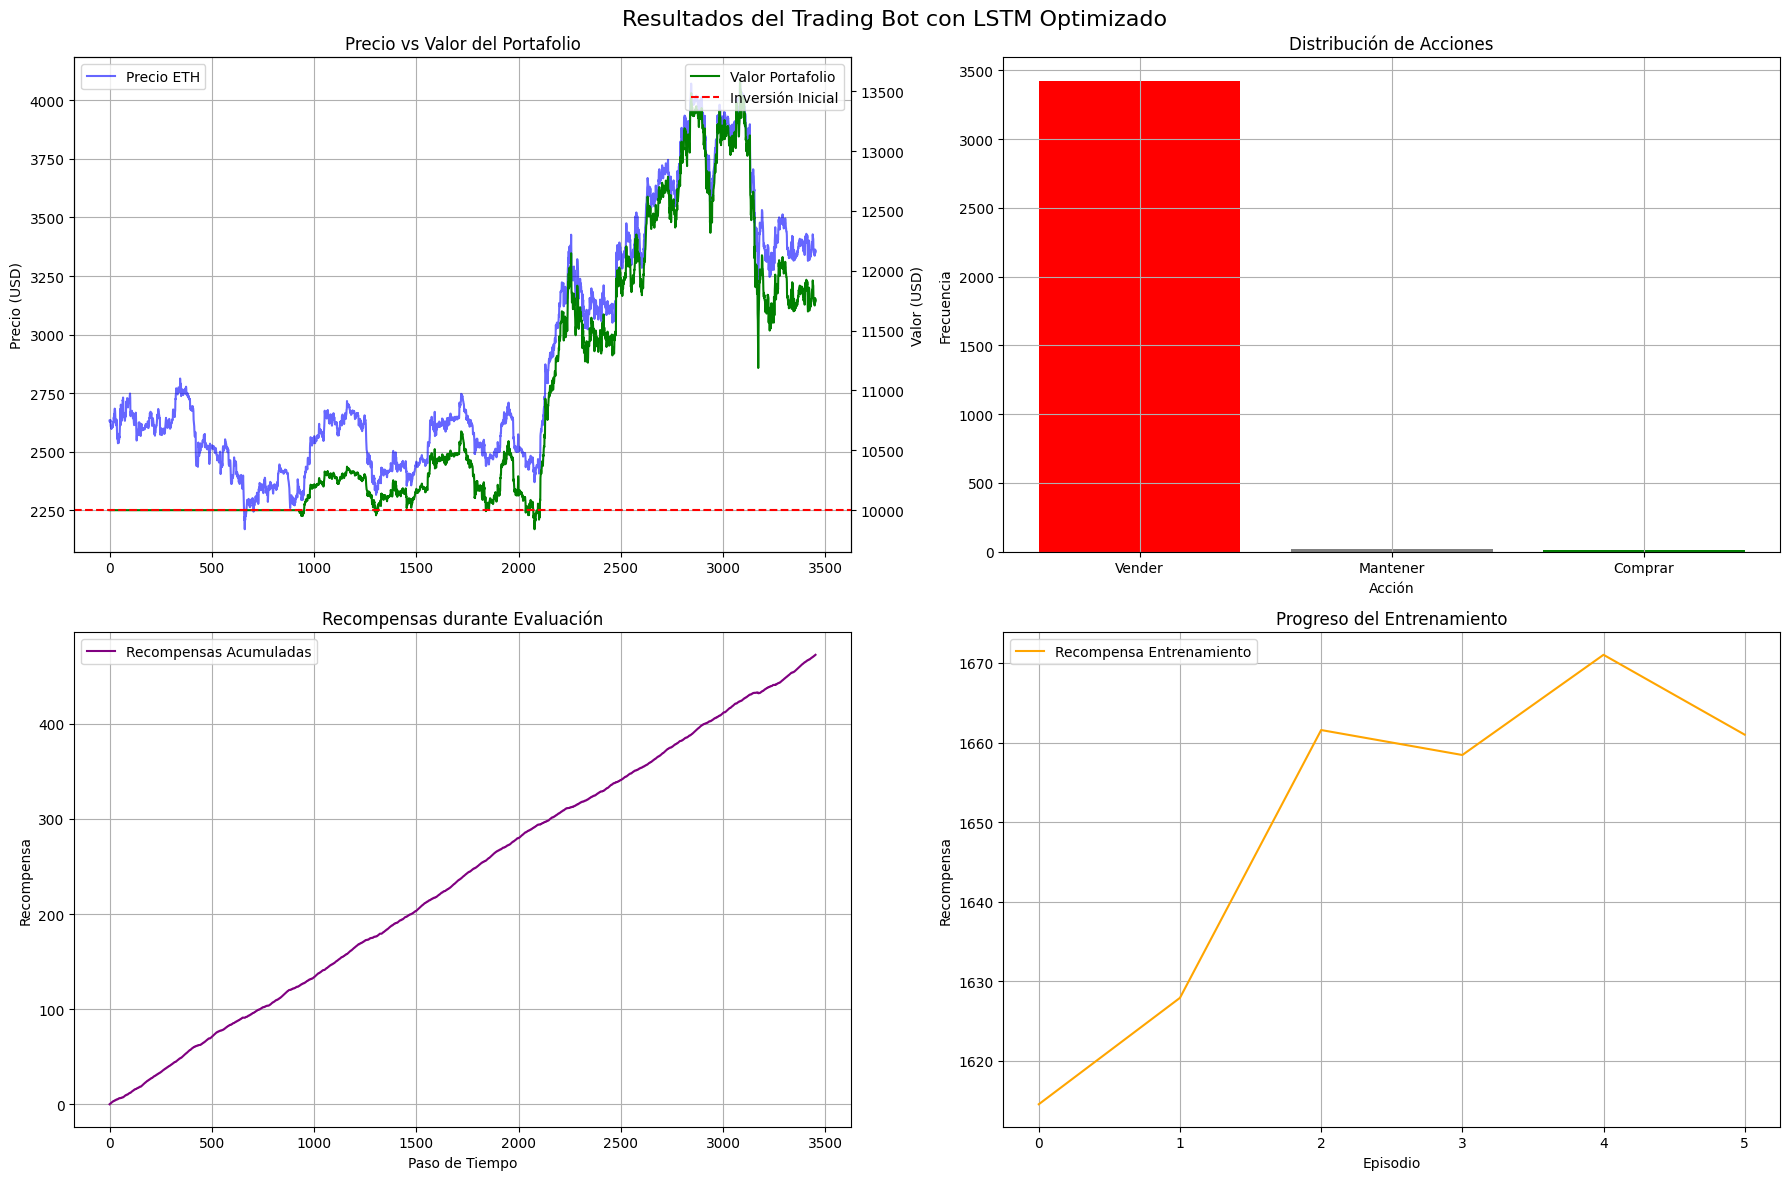

In [ ]:
# --- Visualization ---
plt.figure(figsize=(18, 12))
plt.suptitle('Optimized Trading Bot Results with LSTM', fontsize=16)

# Subplot 1: Price vs Portfolio Value
plt.subplot(2, 2, 1)
plt.plot(price_history, label='ETH Price', color='blue', alpha=0.6)
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(portfolio_history[1:], label='Portfolio Value', color='green')
ax2.axhline(y=10000, color='red', linestyle='--', label='Initial Investment')
ax2.set_ylabel('Value (USD)')
ax2.legend(loc='upper right')
plt.title('Price vs Portfolio Value')

# Subplot 2: Action Distribution
plt.subplot(2, 2, 2)
action_names = ['Sell', 'Hold', 'Buy']
action_counts = pd.Series(actions_history).value_counts()
plt.bar(action_names, action_counts, color=['red', 'gray', 'green'])
plt.xlabel('Action')
plt.ylabel('Frequency')
plt.title('Action Distribution')
plt.grid(True)

# Subplot 3: Cumulative Rewards
plt.subplot(2, 2, 3)
cumulative_rewards = np.cumsum(rewards_history)
plt.plot(cumulative_rewards, label='Cumulative Rewards', color='purple')
plt.xlabel('Time Step')
plt.ylabel('Reward')
plt.title('Cumulative Rewards')
plt.legend()
plt.grid(True)

# Subplot 4: Training Progress
plt.subplot(2, 2, 4)
plt.plot(train_rewards, label='Training Reward', color='orange')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Progress')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()